In [10]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as spop
import seaborn as sns; sns.set()
import yfinance as yf
%matplotlib inline

In [64]:
class pairs_trading:
    start = '2017-12-31'
    end = '2021-07-01'
    fee = 0.001
    window = 252
    t_threshold = -2.5
    position0 = 0
    position1 = 0
    

    def __init__(self, asset_a, asset_b, start = start, end = end, beta_loading = 0, entry = 0.2, stop_loss = 0.05):
        
        self.asset_a = asset_a
        self.asset_b = asset_b

    def data(self):
        
        # a1 = yf.download(self.asset_a, start, end)
        # a2 = yf.download(self.asset_b, start, end)
        
        a1 = pdr.get_data_yahoo(self.asset_a, start, end)
        a2 = pdr.get_data_yahoo(self.asset_b, start, end)

        prices = pd.DataFrame()
        prices[self.asset_a] = a1['Adj Close']
        prices[self.asset_b] = a2['Adj Close']

        returns = pd.DataFrame()
        returns[self.asset_a] = np.append(prices[self.asset_a][1:].reset_index(drop=True) / prices[self.asset_a][:-1].reset_index(drop=True) -1, 0)
        returns[self.asset_b] = np.append(prices[self.asset_b][1:].reset_index(drop=True) / prices[self.asset_b][:-1].reset_index(drop=True) -1, 0)

        corr = np.corrcoef(returns[self.asset_a], returns[self.asset_b])[0]
        print(f"Correlation Coefficient between {self.asset_a} and {self.asset_b}: " + str(round(corr[1] * 100, 3)) + '%')

        return prices, returns

    def visualise(self):
        with plt.style.context('dark_background'):
            plt.figure(figsize = (30,10))
            plt.plot(prices[self.asset_a], label = self.asset_a)
            plt.plot(prices[self.asset_b], label = self.asset_b)
            plt.title(self.asset_a + ' vs. ' + self.asset_b, fontsize = 18)
            plt.ylabel('Stock Price', fontsize = 14)
            plt.xlabel('Date from ' + start + ' to ' + end, fontsize = 14)
            plt.legend()
            plt.show()

    def trade(self):
        
  
        # Initialising the Arrays
        gross_returns = np.array([])
        net_returns = np.array([])
        market_returns = np.array([])
        signals = np.array([])
        t_statistic = np.array([])

        # Moving through the sample
        for t in range(self.window, len(prices)):

          # We now define the unit root function: asset_b = a + b * asset_a
            def unit_root(b):
                a = np.average(prices[self.asset_b][t-self.window:t] - b*prices[self.asset_a][t-self.window:t])
                fair_value = a + b*prices[self.asset_a][t-self.window:t]
                difference = np.array(fair_value - prices[self.asset_b][t-self.window:t])
                diff_diff = difference[1:] - difference[:-1]
                reg = sm.OLS(diff_diff, difference[:-1])
                result = reg.fit()
                return result.params[0]/result.bse[0]

            # Optimising the cointergration equation parameters
            result1 = spop.minimize(unit_root, prices[self.asset_b][t] / prices[self.asset_a][t], method = 'Nelder-Mead')
            t_optimal = result1.fun
            b_optimal = float(result1.x)
            a_optimal = np.average(prices[self.asset_b][t-self.window:t] - b_optimal*prices[self.asset_a][t-self.window:t])

            # Simulating returns
            fair_value = a_optimal + b_optimal * prices[self.asset_a][t]
            if t == self.window:
                old_signal = 0
            if t_optimal > self.t_threshold:
                signal = 0
                gross_return = 0
            else:
                signal = np.sign(fair_value - prices[self.asset_b][t])
                gross_return = signal * returns[self.asset_b][t] - signal * returns[self.asset_a][t]

            fees = self.fee * abs(signal - old_signal)
            net_return = gross_return - fees

            gross_returns = np.append(gross_returns, gross_return)
            net_returns = np.append(net_returns, net_return)
            t_statistic = np.append(t_statistic, t_optimal)

        old_signal = signal

        with plt.style.context ('dark_background'):

            plt.figure(figsize=(30,10))
            plt.plot(np.append(1, np.cumprod(1+gross_returns)), label = 'Gross Returns')
            plt.plot(np.append(1, np.cumprod(1+net_returns)), label = 'Net Returns')
            plt.title('Pairs Trading Strategy using ' + self.asset_a + ' and ' + self.asset_b, fontsize = 18)
            plt.legend()
            plt.ylabel('Returns', fontsize = 14)
            plt.xlabel('Number of Time Periods between ' + start + ' and ' + end, fontsize = 14)

        plt.show()
        
        print('Cumulative Gross Return: ' + str(round(np.prod(1 + gross_returns) * 100 - 100, 2)) + '%')
        print('Cumulative Net Return: ' + str(round(np.prod(1 + net_returns) * 100 - 100, 2)) + '%')

Correlation Coefficient between JPM and GS: 85.589%


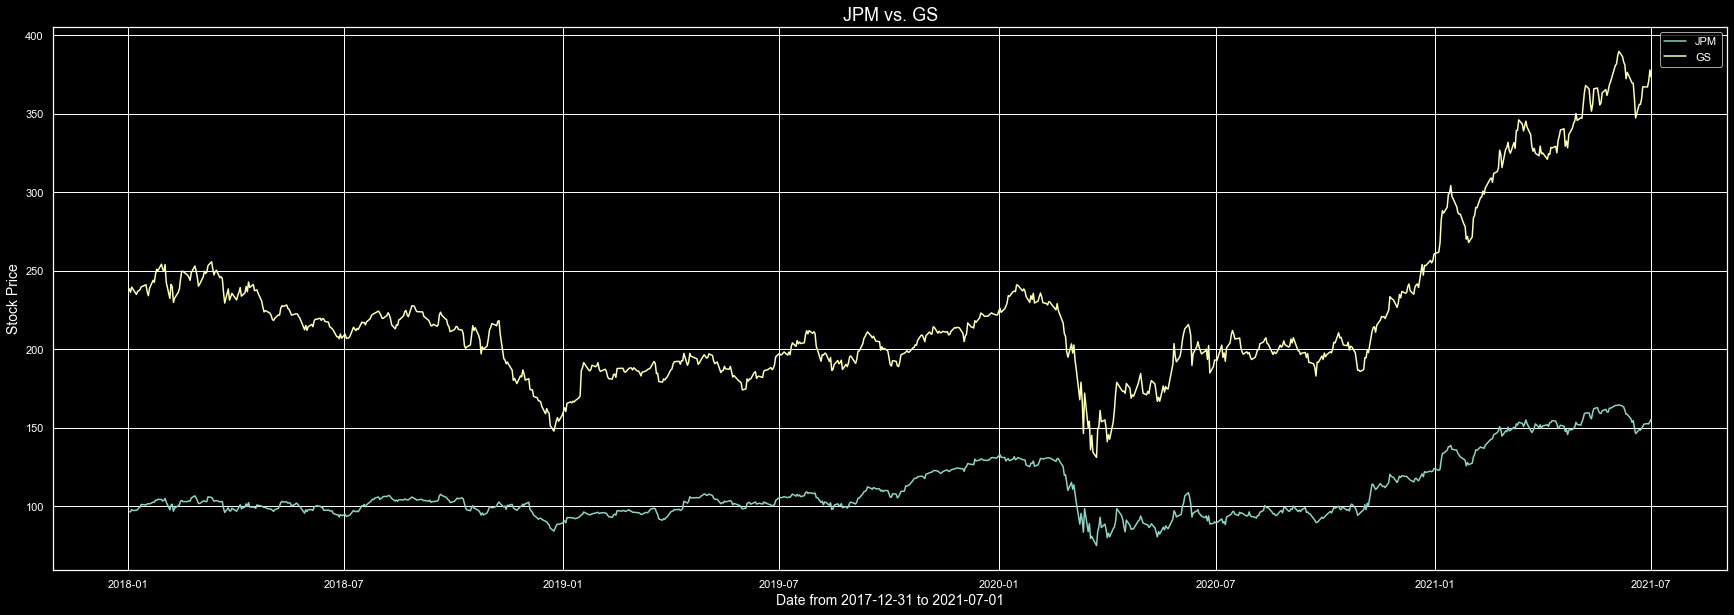

In [65]:
if __name__ == '__main__':
    
    pair = ['JPM', 'GS']
    start = '2017-12-31'
    end = '2021-07-01'
    prices, returns = pairs_trading(pair[0], pair[1], start, end).data()
    pairs_trading(pair[0], pair[1], start, end).visualise 

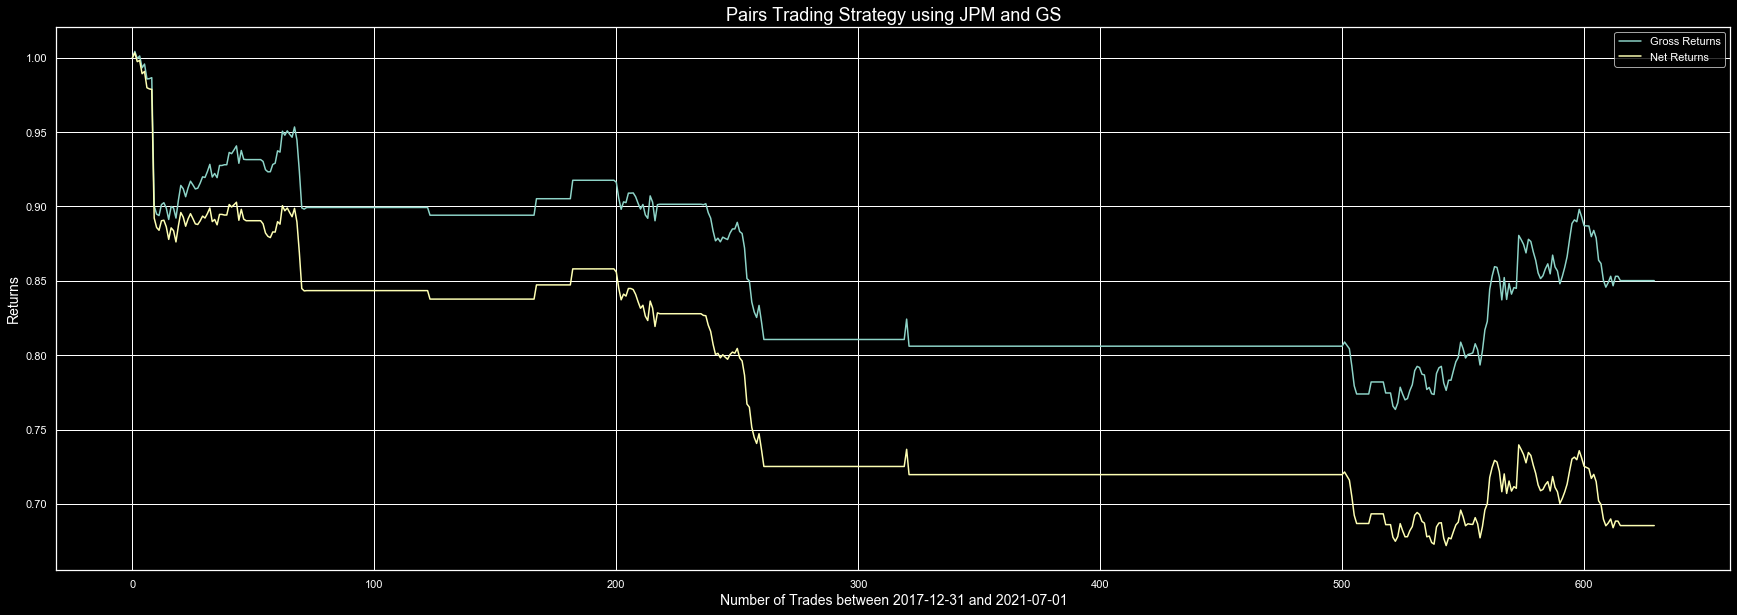

Cumulative Gross Return: -14.99%
Cumulative Net Return: -31.45%


In [66]:
pairs_trading(pair[0], pair[1], start, end).trade()